## Preparation and Evaluation of an Air Pollution Forecasting Model for the Position of ML Engineer at S.M.O.G. (University Project)
### Kyryl Stavratii

----------


In [1]:
import sys
import pandas as pd
import numpy as np
import requests
import tempfile, os, zipfile
import os
import sqlite3
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2025-01-12 21:53:04.467635: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_names_without_year = ["_PM10_24g", "_PM10_1g", 
                           "_PM25_24g", "_PM25_1g"]

In [3]:
def get_data_from_site(file_name):
    dir_name = 2023
    for i in range(1, 296): # Pomiary od 2018 do 2023  = 296
        print(f"Swap number {i} to {i+1}...")
        try :
            print(f"Dir name = {dir_name}")
            print(f"{565-i}")
            response = requests.get(f"https://powietrze.gios.gov.pl/pjp/archives/downloadFile/{565-i}")
            file = tempfile.TemporaryFile()
            file.write(response.content)
            fzip = zipfile.ZipFile(file)
            fzip.extract(f"{dir_name}{file_name}.xlsx", f'/Users/kirill/Desktop/Study/Project_12.01.24/{dir_name}')
            file.close()
            fzip.close()
            dir_name = dir_name - 1
            print("File upload...")
        except:
            print("Continue...")
def get_meta_data():
    response = requests.get(f"https://powietrze.gios.gov.pl/pjp/archives/downloadFile/562")
    with open("data_meta.xlsx","wb") as file:
        file.write(response.content)
    print("Meta data is ok")

def load_all_data():
    for file_name in file_names_without_year:
        get_data_from_site(file_name)
    get_meta_data()


### A Function to Download All Necessary Data for Analysis

In [4]:
# load_all_data()

In [5]:
def check_null(df):
    print("All null")
    print(df.isnull().sum().sort_values())
def write_to_db(df,name_table, db):
    df.to_sql(name_table,db , if_exists='replace')

-------

## 1. Data Retrieval from Local Sources, Storing in a Database, and Processing

In [6]:
file_paths_10 = [
    "2018/2018_PM10_24g.xlsx",
    "2019/2019_PM10_24g.xlsx",
    "2020/2020_PM10_24g.xlsx",
    "2021/2021_PM10_24g.xlsx",
    "2022/2022_PM10_24g.xlsx",
    "2023/2023_PM10_24g.xlsx"
]
file_paths_25 = [
    "2018/2018_PM25_24g.xlsx",
    "2019/2019_PM25_24g.xlsx",
    "2020/2020_PM25_24g.xlsx",
    "2021/2021_PM25_24g.xlsx",
    "2022/2022_PM25_24g.xlsx",
    "2023/2023_PM25_24g.xlsx"
]

db = sqlite3.connect("test.db")

for i in [file_paths_10,file_paths_25]:
    data_for_combination = []
    for file_path in i:
        print(f"next step {file_path}")
        dfs = pd.read_excel(file_path)
        dfs = dfs.drop([1,2,3,4])
        dfs.iloc[0,0] = "Date"
        dfs = dfs.rename(dfs.loc[0], axis=1)
        dfs = dfs.drop(0)
        dfs = dfs.reset_index(drop=True)
        data_for_combination.append(dfs)

    if i == file_paths_10:
        data_PM10_24g_combined = pd.concat(data_for_combination)
    else:
        data_PM25_24g_combined = pd.concat(data_for_combination)
meta_data = pd.read_excel("data_meta.xlsx")

write_to_db(data_PM10_24g_combined,"PM10_short", db)
write_to_db(data_PM25_24g_combined,"PM2.5_short", db)
write_to_db(meta_data,"meta", db)

next step 2018/2018_PM10_24g.xlsx


next step 2019/2019_PM10_24g.xlsx
next step 2020/2020_PM10_24g.xlsx
next step 2021/2021_PM10_24g.xlsx
next step 2022/2022_PM10_24g.xlsx
next step 2023/2023_PM10_24g.xlsx
next step 2018/2018_PM25_24g.xlsx
next step 2019/2019_PM25_24g.xlsx
next step 2020/2020_PM25_24g.xlsx
next step 2021/2021_PM25_24g.xlsx
next step 2022/2022_PM25_24g.xlsx
next step 2023/2023_PM25_24g.xlsx


In [7]:
def make_long_format_and_first_prepare():
    data_PM25_24g_cleaned = data_PM25_24g_combined.loc[:, data_PM25_24g_combined.isnull().sum() <= round(data_PM25_24g_combined.shape[0]*0.3)]
    data_PM10_24g_cleaned = data_PM10_24g_combined.loc[:, data_PM10_24g_combined.isnull().sum() <= round(data_PM10_24g_combined.shape[0]*0.3)]
    data_PM10_24g_long = data_PM10_24g_cleaned.melt(id_vars=["Date"], var_name="Station",value_name="PM10")
    data_PM25_24g_long = data_PM25_24g_cleaned.melt(id_vars=["Date"], var_name="Station",value_name="PM25")
    df = pd.merge(data_PM25_24g_long,data_PM10_24g_long,on=["Date","Station"])
    df.iloc[:,-2:] = df.iloc[:,-2:].astype(str)
    df.iloc[:,-2:] = df.iloc[:,-2:].apply(lambda col: col.str.replace(",","."))
    df.iloc[:,-2:] = df.iloc[:,-2:].astype(float)
    return df

In [8]:
df_long = make_long_format_and_first_prepare()

------

## 2. Filling Missing Data Using Correlation Between PM10 and PM2.5

In [9]:
check_null(df_long)

All null
Date          0
Station       0
PM10       2406
PM25       3152
dtype: int64


There is correlation between PM10 and PM2.5 , and the result is statistically sighificant 
Correlation = 0.9580319672153456 and P-value = 0.0


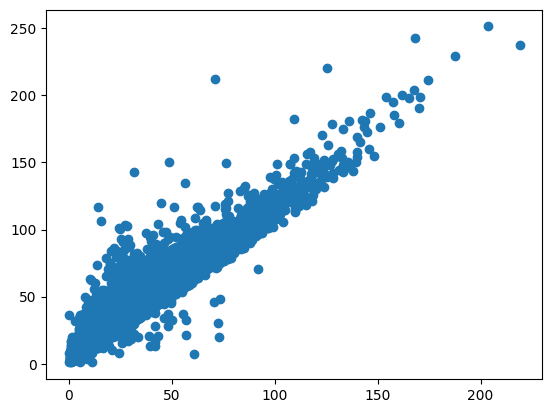

In [10]:
def draw_plot_corr_PM10_PM25(df):
    df_without_null = df.dropna(subset=["PM10","PM25"])

    corr_pearson , p_value = pearsonr(df_without_null["PM10"].astype(float),df_without_null["PM25"].astype(float))

    if p_value < 0.05:
        print("There is correlation between PM10 and PM2.5 , and the result is statistically sighificant ")
        print(f"Correlation = {corr_pearson} and P-value = {p_value}")
    else:
        print("No correlation was found between PM10 and PM2.5, or the result is not statistically sighificant")
        print(f"Correlation = {corr_pearson} and P-value = {p_value}")

    plt.scatter(df_without_null["PM25"], df_without_null["PM10"])
draw_plot_corr_PM10_PM25(df_long)

In [11]:
def impute_with_corr_data(df,corr_column_name: str, imputable_column_name: str):
    
    train_data = df.dropna(subset=[corr_column_name]).dropna(subset=[imputable_column_name])

    X_train = train_data[[imputable_column_name]]  
    y_train = train_data[corr_column_name]

    model = LinearRegression()
    model.fit(X_train, y_train)

    X_missing = df[df[corr_column_name].isna()][[imputable_column_name]].dropna()
    predicted_pm = model.predict(X_missing)

    df.loc[df[corr_column_name].isna() & df[imputable_column_name].notna(), corr_column_name] = predicted_pm

def impute_with_neighbors(df):
    imputer = KNNImputer(n_neighbors=5)

    df[['PM10', 'PM25']] = imputer.fit_transform(df[['PM10', 'PM25']])

In [12]:
impute_with_corr_data(df_long,"PM10","PM25")
impute_with_corr_data(df_long,"PM25","PM10")
impute_with_neighbors(df_long)
check_null(df_long)

All null
Date       0
Station    0
PM25       0
PM10       0
dtype: int64


In [13]:
df_long.head()

,Date,Station,PM25,PM10
0,2018-01-01,DsOsieczow21,11.30,13.81
1,2018-01-02,DsOsieczow21,7.91,9.26
2,2018-01-03,DsOsieczow21,6.62,7.80
3,2018-01-04,DsOsieczow21,8.18,12.08
4,2018-01-05,DsOsieczow21,8.37,11.98


## 3. Integration of Data with Geographic Information, Adding New Features, and Formatting for Easier Analysis

In [15]:
df_meta = pd.read_excel("data_meta.xlsx")
df_meta = df_meta.iloc[:,[1,-5,-2,-1]].rename(columns={"Kod stacji": "Station","WGS84 φ N": "Latitude", "WGS84 λ E": "Longitude"})

In [16]:
df_meta.head()

,Station,Województwo,Latitude,Longitude
0,DsBialka,DOLNOŚLĄSKIE,51.197783,16.117390
1,DsBielGrot,DOLNOŚLĄSKIE,50.682510,16.617348
2,DsBogatFrancMOB,DOLNOŚLĄSKIE,50.940998,14.916790
3,DsBogChop,DOLNOŚLĄSKIE,50.905856,14.967175
4,DsBogZatonieMob,DOLNOŚLĄSKIE,50.943245,14.913327


In [17]:
df_merged = pd.merge(df_long,df_meta,on=["Station"])

In [18]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'  
    elif month in [3, 4, 5]:
        return 'Spring'  
    elif month in [6, 7, 8]:
        return 'Summer'  
    elif month in [9, 10, 11]:
        return 'Autumn'  


def lag_lunc(df, max_lags=30):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Station', 'Date'], inplace=True)
    for lag in range(1, max_lags + 1):
        df[f'lag_{lag}'] = df.groupby('Station')['PM25'].shift(lag)
    df.reset_index(inplace=True)

def rolling_func(df, rolling_window=4):
    df['rolling_mean'] = df['PM25'].rolling(window=rolling_window).mean()

    df['rolling_std'] = df['PM25'].rolling(window=rolling_window).std()

    df['rolling_min'] = df['PM25'].rolling(window=rolling_window).min()

    df['rolling_max'] = df['PM25'].rolling(window=rolling_window).max()

In [19]:
df_merged["Year"] = df_merged["Date"].dt.year
df_merged["Month"] = df_merged["Date"].dt.month
df_merged["Day"] = df_merged["Date"].dt.day
df_merged["Day_of_week"] = df_merged["Date"].dt.day_of_week.apply(lambda x: x+1)
df_merged["Quarter"] = df_merged["Date"].dt.quarter
df_merged["Season"] = df_merged["Date"].apply(lambda x: get_season(x))
lag_lunc(df_merged)
rolling_func(df_merged)
df_merged.dropna(inplace=True)

In [119]:
df_merged.head()

,Station,Date,PM25,PM10,Województwo,Latitude,Longitude,Year,Month,Day,...,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean,rolling_std,rolling_min,rolling_max
30,DsOsieczow21,2018-01-31,10.31,12.64,DOLNOŚLĄSKIE,51.31763,15.431719,2018,1,31,...,13.76,8.37,8.18,6.62,7.91,11.30,8.1850,2.988874,4.84,11.07
31,DsOsieczow21,2018-02-01,10.14,12.24,DOLNOŚLĄSKIE,51.31763,15.431719,2018,2,1,...,15.64,13.76,8.37,8.18,6.62,7.91,7.9525,2.713096,4.84,10.31
32,DsOsieczow21,2018-02-02,13.85,16.81,DOLNOŚLĄSKIE,51.31763,15.431719,2018,2,2,...,20.57,15.64,13.76,8.37,8.18,6.62,10.2050,2.993354,6.52,13.85
33,DsOsieczow21,2018-02-03,11.10,12.70,DOLNOŚLĄSKIE,51.31763,15.431719,2018,2,3,...,34.84,20.57,15.64,13.76,8.37,8.18,11.3500,1.718352,10.14,13.85
34,DsOsieczow21,2018-02-04,12.83,14.01,DOLNOŚLĄSKIE,51.31763,15.431719,2018,2,4,...,39.40,34.84,20.57,15.64,13.76,8.37,11.9800,1.671267,10.14,13.85


## 4. Preparing Data for the Model

In [20]:

X = pd.get_dummies(data=df_merged,dtype=float,columns=["Season"]).drop("Date",axis=1)
X = pd.get_dummies(data=X,dtype=float,columns=["Województwo"],prefix="Province")
X = pd.get_dummies(data=X,dtype=float,columns=["Station"],prefix="Station")
X.loc[:,["PM10","PM25"]] = X.loc[:,["PM10","PM25"]].apply(lambda x: round(x,2))

In [197]:
X.head()

,PM25,PM10,Latitude,Longitude,Year,Month,Day,Day_of_week,Quarter,lag_1,...,Station_SlKatoKossut,Station_SlTarnoLitew,Station_SlZorySikor2,Station_WmElbBazynsk,Station_WmOlsPuszkin,Station_WmPuszczaBor,Station_WpKaliSawick,Station_WpPleszAlMic,Station_ZpMyslZaBram,Station_ZpSzczec1Maj
30,10.31,12.64,51.31763,15.431719,2018,1,31,3,1,6.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,10.14,12.24,51.31763,15.431719,2018,2,1,4,1,10.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,13.85,16.81,51.31763,15.431719,2018,2,2,5,1,10.14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,11.10,12.70,51.31763,15.431719,2018,2,3,6,1,13.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,12.83,14.01,51.31763,15.431719,2018,2,4,7,1,11.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
coordinates = X[["Latitude", "Longitude"]]
scaler = StandardScaler()
scaler.fit_transform(coordinates)

X[["Latitude", "Longitude"]] = scaler.fit_transform(coordinates)

In [125]:
X.head()

,PM25,PM10,Latitude,Longitude,Year,Month,Day,Day_of_week,Quarter,lag_1,...,Station_SlKatoKossut,Station_SlTarnoLitew,Station_SlZorySikor2,Station_WmElbBazynsk,Station_WmOlsPuszkin,Station_WmPuszczaBor,Station_WpKaliSawick,Station_WpPleszAlMic,Station_ZpMyslZaBram,Station_ZpSzczec1Maj
30,10.31,12.64,-0.208042,-1.599916,2018,1,31,3,1,6.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,10.14,12.24,-0.208042,-1.599916,2018,2,1,4,1,10.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,13.85,16.81,-0.208042,-1.599916,2018,2,2,5,1,10.14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,11.10,12.70,-0.208042,-1.599916,2018,2,3,6,1,13.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,12.83,14.01,-0.208042,-1.599916,2018,2,4,7,1,11.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


------

## 5. Model Creation and Machine Learning

In [22]:
y = X['PM25']
X = X.drop(columns=['PM25',"PM10"])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {test_mae:.2f}")

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Sqeared Error (RMSE):", rmse)
print("R^2 Score:", r2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 92.0665 - mean_absolute_error: 5.8046 - val_loss: 13.8418 - val_mean_absolute_error: 2.4866
Epoch 2/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 10.2509 - mean_absolute_error: 2.1887 - val_loss: 5.5126 - val_mean_absolute_error: 1.6253
Epoch 3/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.3424 - mean_absolute_error: 1.3293 - val_loss: 1.8996 - val_mean_absolute_error: 1.0327
Epoch 4/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4150 - mean_absolute_error: 0.8877 - val_loss: 1.0460 - val_mean_absolute_error: 0.7662
Epoch 5/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8616 - mean_absolute_error: 0.6952 - val_loss: 0.8111 - val_mean_absolute_error: 0.6592
Epoch 6/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7864 - mean_absolute_error: 0.6570 - val_loss: 0.8040 - val_mean_absolute_error: 0.6616
Epoch 7/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6448 - mean_absolute_

------


## 6. Conclusions

### **Key Metrics and Their Implications**
##### MSE (Mean Squared Error): Low value, indicating high precision and small average prediction errors.
##### MAE (Mean Absolute Error): Low value, reflecting accurate predictions close to actual values.

####  **1. Model Fit:**
##### - The model exhibits excellent performance, as evidenced by low error metrics (MAE, RMSE) and a high R^2.
##### - These results suggest that the model effectively captures the underlying patterns in the data.


####  **2. Potential Overfitting:**
##### - The very high  may indicate overfitting, especially if the model’s performance is significantly better on training data compared to unseen test data.
##### - Further validation on independent datasets is essential to ensure generalizability.


####  **3. Next Steps:**
##### - Perform rigorous cross-validation and test set evaluation to confirm the robustness of the model.
##### - Regularize the model or simplify features if overfitting is confirmed.